<a href="https://colab.research.google.com/github/2ZAR/2ZAR/blob/main/%EB%B2%A0%EC%9D%B4%EC%A6%88%EA%B8%B0%EB%A7%90%EA%B3%BC%EC%A0%9C_%ED%86%B5%EA%B3%84_%EA%B9%80%EB%8F%84%EC%98%81.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
set.seed(123)
m <- 1000
samples <- runif(m, 0, pi)
values <- samples^2 * sin(samples)
C_estimate <- pi * mean(values)
C_estimate

[1] 5.859883

In [ ]:
install.packages("ggplot2")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
library(ggplot2)

In [ ]:
f <- function(x) (1/C_estimate) * x^2 * sin(x)
x_v <- seq(0, pi, length.out = 1000)
y_v <- sapply(x_v, f)
df <- data.frame(x = x_v, y = y_v)

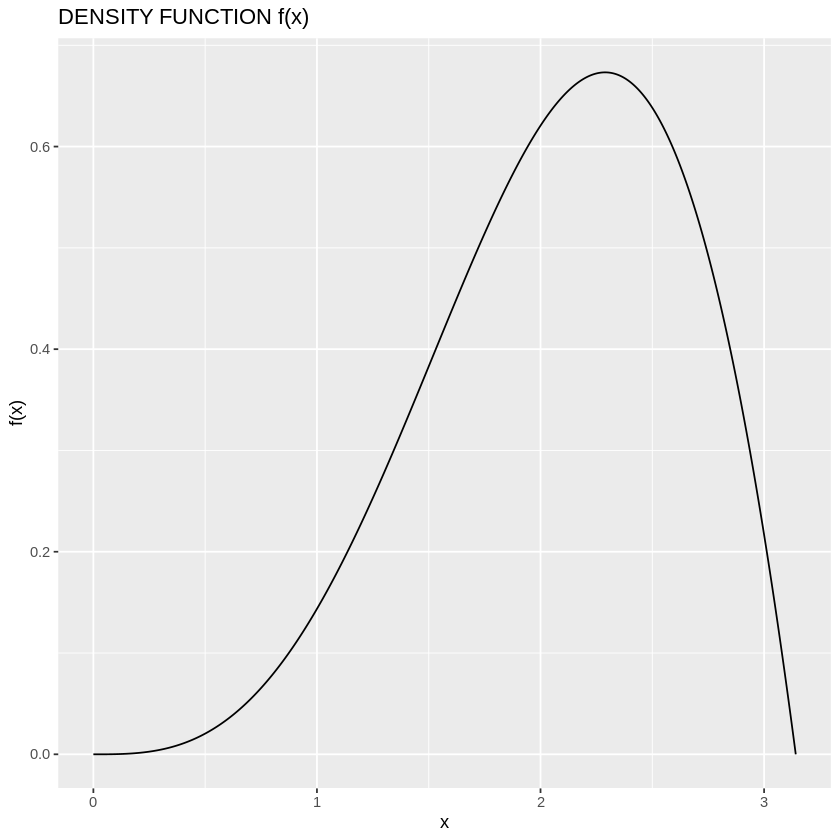

In [ ]:
ggplot(df, aes(x = x, y = y)) + geom_line() +
       ggtitle("DENSITY FUNCTION f(x)") + xlab("x") + ylab("f(x)")


In [ ]:
install.packages("ggmcmc")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘Rcpp’, ‘plyr’, ‘reshape’, ‘GGally’




In [ ]:
library(ggmcmc)

Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: tidyr

Loading required package: ggplot2

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



In [ ]:
install.packages("rstan")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘checkmate’, ‘matrixStats’, ‘StanHeaders’, ‘inline’, ‘gridExtra’, ‘RcppParallel’, ‘loo’, ‘QuickJSR’, ‘RcppEigen’, ‘BH’




In [ ]:
library(rstan)

Loading required package: StanHeaders


rstan version 2.32.3 (Stan version 2.26.1)


For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
For within-chain threading using `reduce_sum()` or `map_rect()` Stan functions,
change `threads_per_chain` option:
rstan_options(threads_per_chain = 1)



Attaching package: ‘rstan’


The following object is masked from ‘package:tidyr’:

    extract




In [ ]:
options(mc.cores = parallel::detectCores())
rstan_options(Auto_write = TRUE)

In [ ]:
data_list <- list(n = 10,
                  x = c(65.9, 55.9, 43.8, 57.7, 68.8, 23.1, 85.4, 62.8, 65.2, 49.9),
                  y = c(68.3, 85.7, 73.8, 83.2, 58.9, 72.7, 70.5, 58.7, 74.1, 75))

In [ ]:
write("//Stan Model
 data {int<lower=0> n; vector[n] x; vector[n] y;}
 parameters {real mean1994; real mean2014; real<lower=0> sd1994; real<lower=0> sd2014;}
 model {x ~ normal(mean1994, sd1994); y ~ normal(mean2014, sd2014); target += -log(sd1994); target += -log(sd2014);}//",
 "Stan_Model.stan")

In [ ]:
stanc("Stan_Model.stan")$status

[1] TRUE

In [ ]:
stan_model1 <- "Stan_Model.stan"

In [ ]:
fit <- stan(file = stan_model1, data = data_list, warmup = 5000, iter = 15000, seed=1234)

In [ ]:
print(fit)

Inference for Stan model: anon_model.
4 chains, each with iter=15000; warmup=5000; thin=1; 
post-warmup draws per chain=10000, total post-warmup draws=40000.

           mean se_mean   sd   2.5%    25%    50%    75%  97.5% n_eff Rhat
mean1994  57.83    0.03 5.95  45.90  54.17  57.81  61.52  69.75 29213    1
mean2014  72.09    0.02 3.17  65.80  70.12  72.09  74.05  78.46 25000    1
sd1994    18.23    0.03 4.93  11.46  14.79  17.30  20.62  30.34 25642    1
sd2014     9.64    0.02 2.65   6.03   7.81   9.15  10.87  16.22 22692    1
lp__     -61.02    0.01 1.57 -64.99 -61.80 -60.65 -59.86 -59.07 15022    1

Samples were drawn using NUTS(diag_e) at Sun Nov 19 09:31:03 2023.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


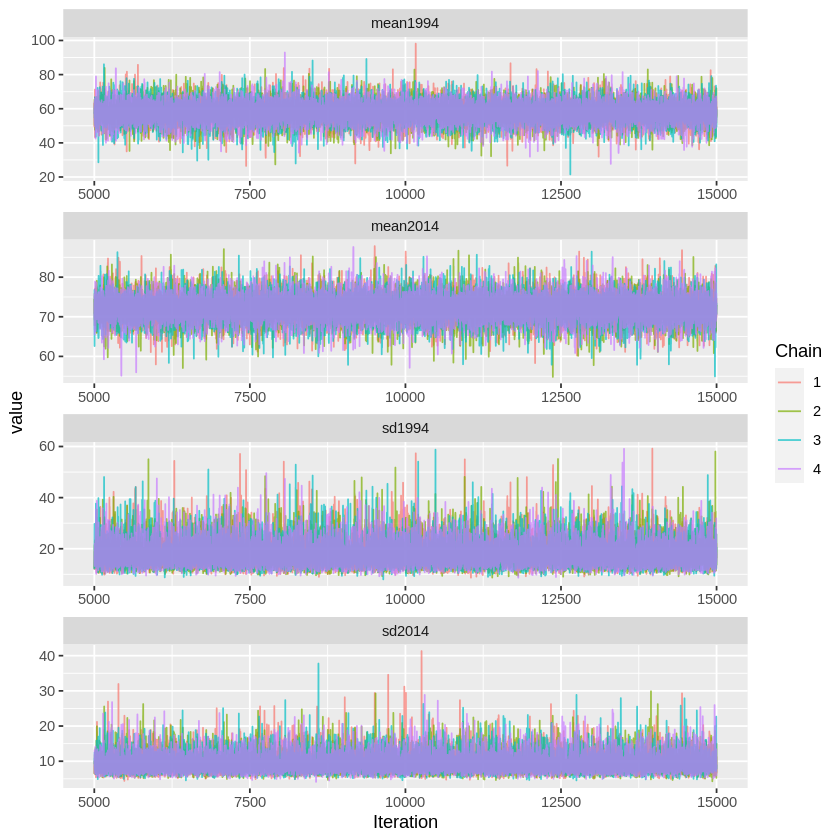

In [ ]:
ggs_traceplot(ggs(fit))

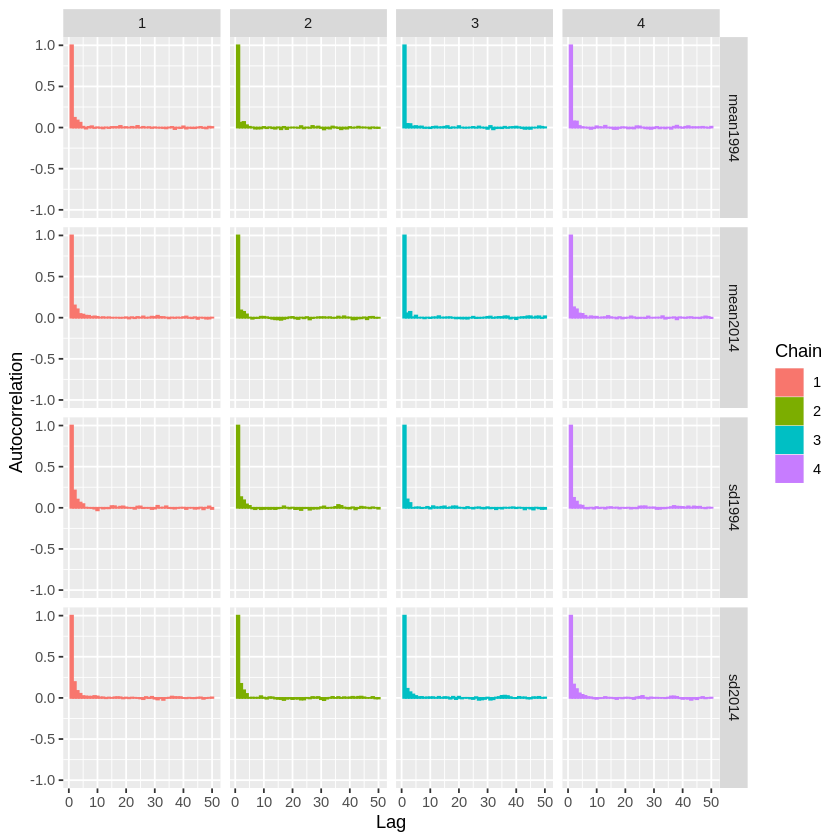

In [ ]:
ggs_autocorrelation(ggs(fit))

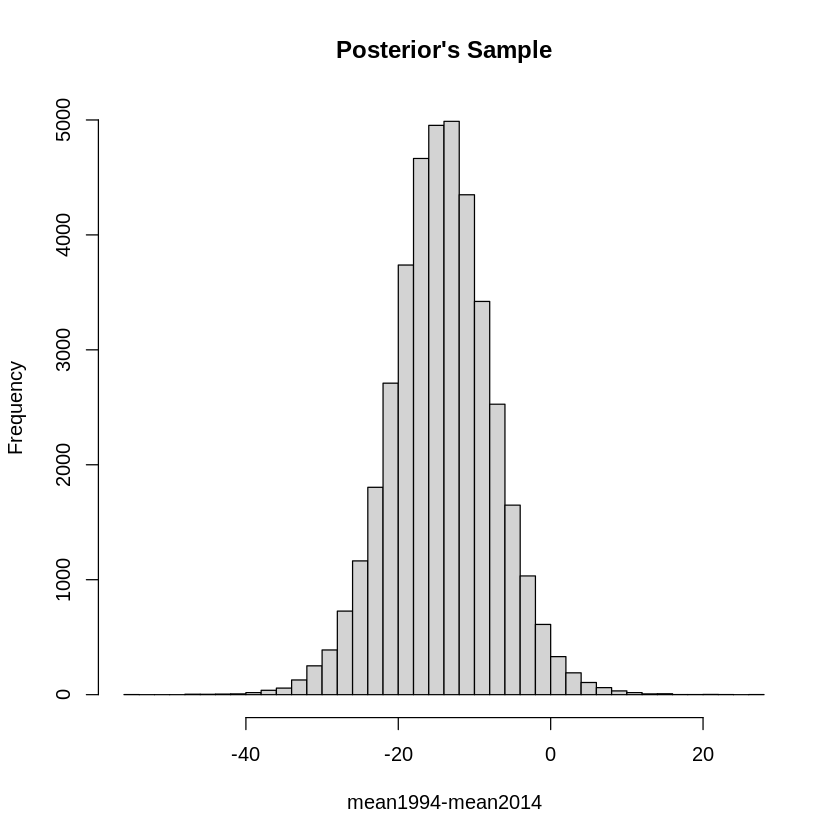

In [ ]:
samples <- rstan::extract(fit)
hist(samples$mean1994 - samples$mean2014, breaks = 50, main="Posterior's Sample", xlab = "mean1994-mean2014")

In [ ]:
posterior_mean <- mean(samples$mean1994 - samples$mean2014)
cat("Posterior-Mean :", posterior_mean,"\n")

Posterior-Mean : -14.26306 


In [ ]:
posterior_sd <- sd(samples$mean1994 - samples$mean2014)
cat("Posterior-SD :", posterior_sd,"\n")

Posterior-SD : 6.721574 


In [ ]:
quantiles <- quantile(samples$mean1994 - samples$mean2014, probs=c(0.025, 0.975))
cat("95% Credible interval: [", quantiles[1], ", ", quantiles[2], "]\n")

95% Credible interval: [ -27.66489 ,  -0.8969895 ]


In [ ]:
code1 = "functions {
                   real rhoprior(real rho) {
                   return - 0.5 * log1m(square(rho)); // log((1 - rho^2)^(-1/2)
                                           }
                   }
        data {
              int N;
              int D;
              vector[D] Y[N];
             }
        parameters {
                    vector[D] mu;
                    real<lower=0> sigma[D];
                    real<lower=-1, upper=1> rho;
                   }
        transformed parameters {
        cov_matrix[D] cov = [[sigma[1]^2, rho * sigma[1] * sigma[2]],
                            [rho*sigma[1] * sigma[2], sigma[2]^2]];
                               }
        model {
               Y ~ multi_normal(mu, cov);
               target += -log(sigma[1]);
               target += -log(sigma[2]);
               target += rhoprior(rho);
              }
        "

In [ ]:
x1 = c(21.0, 21.0, 22.8, 21.4, 18.7, 18.1, 14.3, 24.4, 22.8, 19.2, 17.8, 16.4, 17.3, 15.2, 10.4, 10.4,
       14.7, 32.4, 30.4, 33.9, 21.5, 15.5, 15.2, 13.3, 19.2, 27.3, 26.0, 30.4, 15.8, 19.7, 15.0, 21.4)
x2 = c(110, 110, 93, 110, 175, 105, 245, 62, 95, 123, 123, 180, 180, 180, 205, 215,
       230, 66, 52, 65, 97, 150, 150, 245, 175, 66, 91, 113, 264, 175, 335, 109)

In [ ]:
df <- data.frame(x1, x2)
data1 <- list(N = nrow(df), D=2, Y = df)

In [ ]:
fit1 <- stan(model_code = code1, data = data1, warmup = 5000, iter = 15000,
             seed = 1234, pars = c("mu", "rho", "sigma"))

In [ ]:
print(fit1)

Inference for Stan model: anon_model.
4 chains, each with iter=15000; warmup=5000; thin=1; 
post-warmup draws per chain=10000, total post-warmup draws=40000.

            mean se_mean    sd    2.5%     25%     50%     75%   97.5% n_eff
mu[1]      20.07    0.01  1.10   17.90   19.35   20.07   20.80   22.26 19219
mu[2]     146.83    0.09 12.55  122.56  138.47  146.78  155.12  171.68 19197
rho        -0.75    0.00  0.08   -0.87   -0.81   -0.76   -0.71   -0.57 21029
sigma[1]    6.17    0.01  0.80    4.83    5.60    6.09    6.64    7.96 18318
sigma[2]   70.19    0.07  9.13   54.98   63.81   69.20   75.60   90.59 18994
lp__     -212.75    0.01  1.65 -216.83 -213.60 -212.42 -211.53 -210.57 16202
         Rhat
mu[1]       1
mu[2]       1
rho         1
sigma[1]    1
sigma[2]    1
lp__        1

Samples were drawn using NUTS(diag_e) at Sun Nov 19 10:24:33 2023.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains 

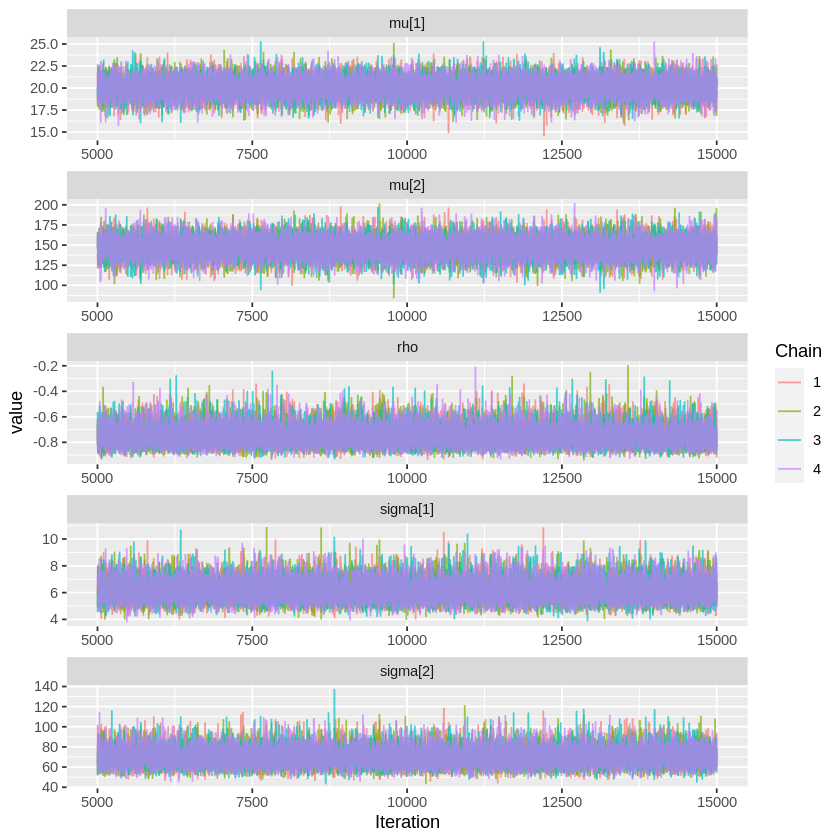

In [ ]:
ggs_traceplot(ggs(fit1))

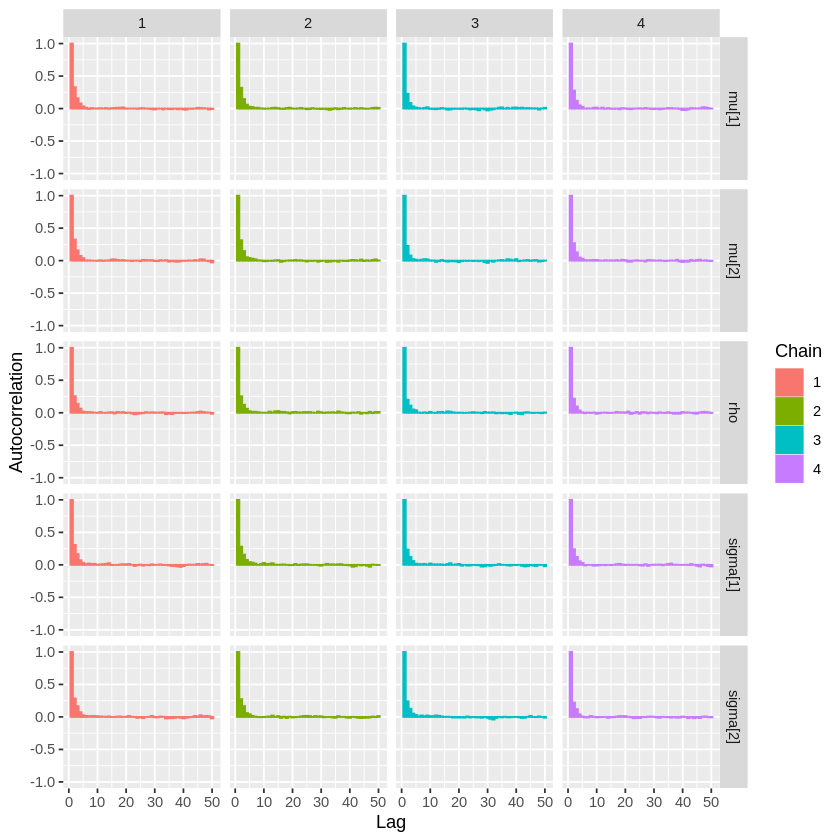

In [ ]:
ggs_autocorrelation(ggs(fit1))

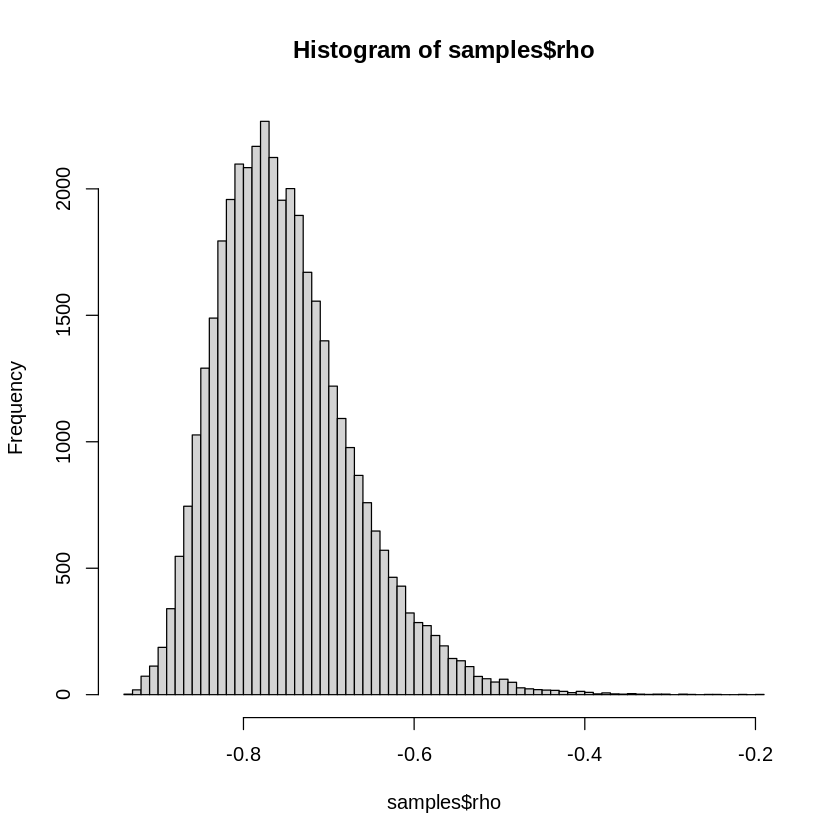

In [ ]:
samples <- rstan::extract(fit1)
hist(samples$rho, breaks=100)

In [ ]:
posterior_rho <- mean(samples$rho)
cat("Posterior Mean : ", posterior_rho, "\n")

Posterior Mean :  -0.7508969 


In [ ]:
posterior_sd <- sd(samples$rho)
cat("Posterior SD : ", posterior_sd, "\n")

Posterior SD :  0.07938203 


In [ ]:
quantiles <- quantile(samples$rho, probs=c(0.025, 0.975))
cat("95% Credible inteval : [", quantiles[1], ", ", quantiles[2], "]\n")

95% Credible inteval : [ -0.8746126 ,  -0.5671782 ]
